In [ ]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import yfinance as yf
import pandas_datareader as pdr  # Access FRED
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# **STEP 3 - Computations**




**Category 5: Linear Discriminant Analysis (LDA)**

The method of LCA is illustrated next. The application case is German credit data, where people are classified as good or bad credit risks based on 20 attributes (such as the status of existing checking account, credit duration and history, etc.). More detailed information about the dataset can be found at https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data.

In [ ]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (all attributes)
X_all = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
#we'll now retrieve only a few numerical attributes, corresponding to numerical data where classification can be applied
X = pd.DataFrame(data = {'duration': X_all['Attribute2'], 'credit_amount': X_all['Attribute5'], 'installment_rate': X_all['Attribute8'], 'age': X_all['Attribute13'], 'n_existing_credits': X_all['Attribute16']})

# create dataset with
df_dataset = pd.DataFrame(X)
df_dataset = df_dataset.join(y)

print(df_dataset)

     duration  credit_amount  installment_rate  age  n_existing_credits  class
0           6           1169                 4   67                   2      1
1          48           5951                 2   22                   1      2
2          12           2096                 2   49                   1      1
3          42           7882                 2   45                   1      1
4          24           4870                 3   53                   2      2
..        ...            ...               ...  ...                 ...    ...
995        12           1736                 3   31                   1      1
996        30           3857                 4   40                   1      1
997        12            804                 4   38                   1      1
998        45           1845                 4   23                   1      2
999        45           4576                 3   27                   1      1

[1000 rows x 6 columns]


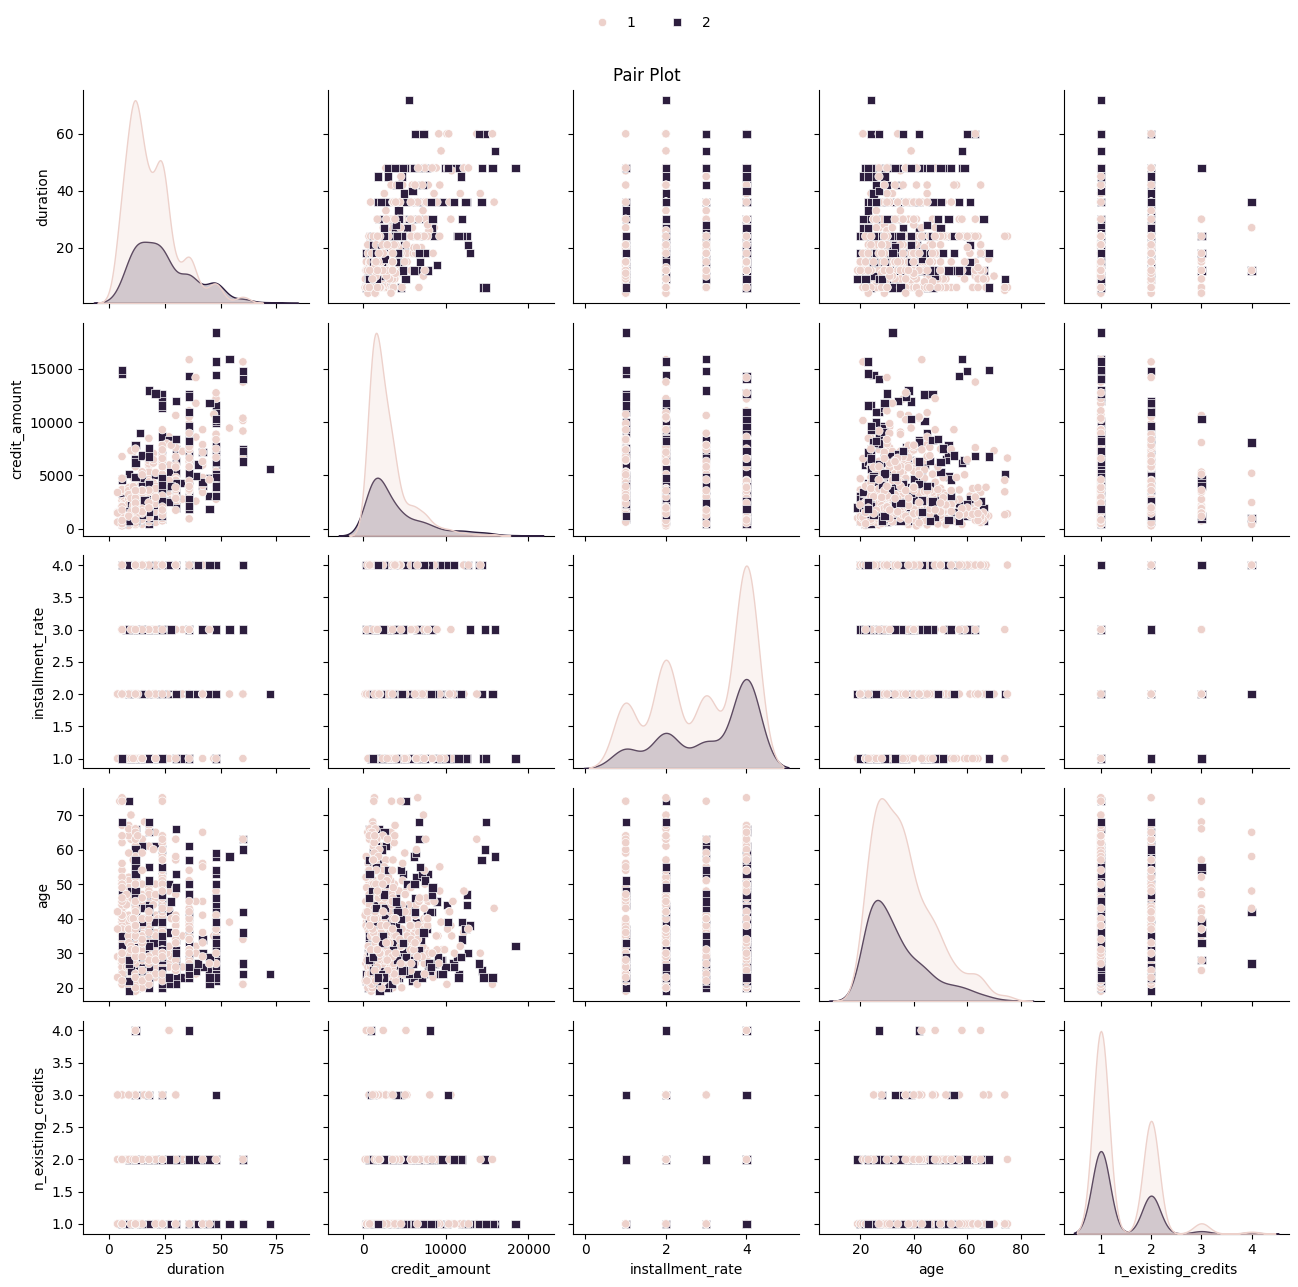

In [ ]:
# Create a pair plot to visualize relationships between different features and species.
ax = sns.pairplot(df_dataset, hue='class', markers=["o", "s"])
plt.suptitle("Pair Plot ")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
plt.tight_layout()
plt.show()

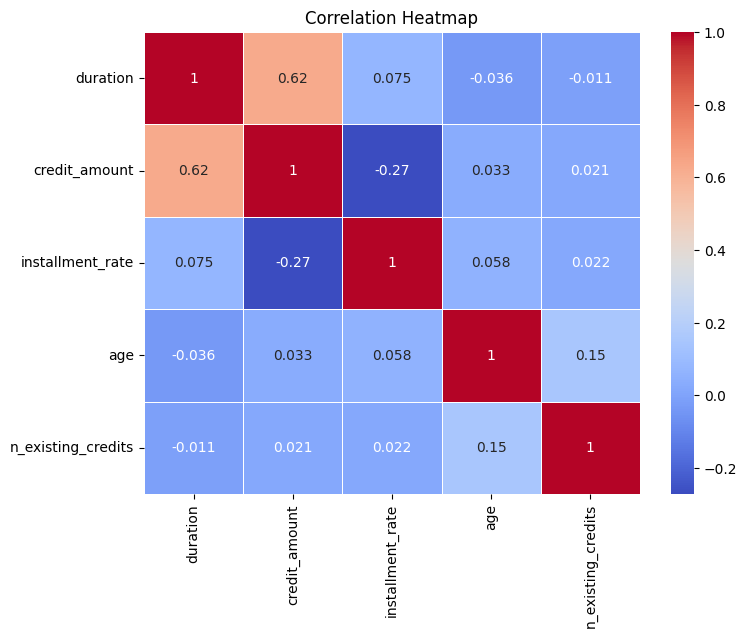

In [ ]:
# check correlation heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#now let's split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# apply LDA now
lda = LinearDiscriminantAnalysis()
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
tmp_Df = pd.DataFrame(X_test, columns=['LDA Component 1'])
tmp_Df['class']=y_train
tmp_Df = tmp_Df.dropna()

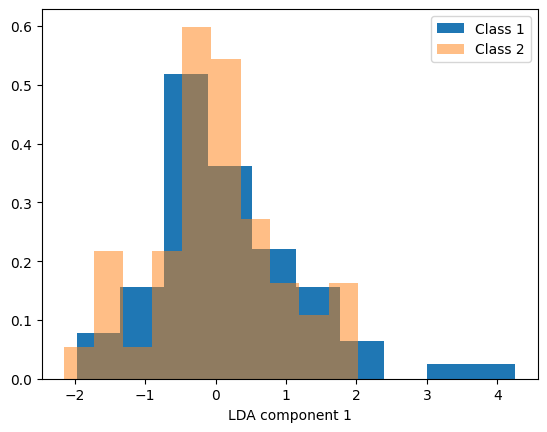

In [ ]:
df_class1 = tmp_Df.loc[tmp_Df['class'] == 1]
df_class2 = tmp_Df.loc[tmp_Df['class'] == 2]

plt.figure()
plt.hist(df_class1['LDA Component 1'], label='Class 1', density=True)
plt.hist(df_class2['LDA Component 1'], alpha = 0.5, label = 'Class 2', density=True)
plt.legend()
plt.xlabel('LDA component 1')
plt.show()
plt.close()



From the previous example, it was observed that using one LDA component (requirement when applying the LinearDiscriminantAnalysis function, since there are two target classes only one LDA component can be used) cannot retrieve differences in the dataset. Let's try now to the the LDA components by resolving an eigenproblem:

In [ ]:

mean_vectors = []
for cl in [1,2]:
    mean_vectors.append(np.mean(X[y.values==cl].values, axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))


Mean Vector class 1: [1.92071429e+01 2.98545714e+03 2.92000000e+00 3.62242857e+01
 1.42428571e+00]

Mean Vector class 2: [2.48600000e+01 3.93812667e+03 3.09666667e+00 3.39633333e+01
 1.36666667e+00]



In [ ]:
S_W = np.zeros((5,5))
for cl,mv in zip([1,2], mean_vectors):
    class_sc_mat = np.zeros((5,5))                  # scatter matrix for every class
    for row in X[y.values == cl].values:
        row, mv = row.reshape(5,1), mv.reshape(5,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[ 1.38559084e+05  2.01215620e+07  7.97660000e+02 -2.26806143e+03
  -1.01214286e+01]
 [ 2.01215620e+07  7.76928399e+09 -8.91258073e+05  1.50179962e+06
   4.54002952e+04]
 [ 7.97660000e+02 -8.91258073e+05  1.24371667e+03  8.24623333e+02
   1.61266667e+01]
 [-2.26806143e+03  1.50179962e+06  8.24623333e+02  1.28198384e+05
   9.52420476e+02]
 [-1.01214286e+01  4.54002952e+04  1.61266667e+01  9.52420476e+02
   3.32653810e+02]]


In [ ]:
overall_mean = np.mean(X.values, axis=0)

S_B = np.zeros((5,5))
for i,mean_vec in enumerate(mean_vectors):
    n = X[y.values==i+1].values.shape[0]
    mean_vec = mean_vec.reshape(5,1) # make column vector
    overall_mean = overall_mean.reshape(5,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 6.71050671e+03  1.13091399e+06  2.09721000e+02 -2.68397657e+03
  -6.83995714e+01]
 [ 1.13091399e+06  1.90591637e+08  3.53440393e+04 -4.52327490e+05
  -1.15273012e+04]
 [ 2.09721000e+02  3.53440393e+04  6.55433333e+00 -8.38813333e+01
  -2.13766667e+00]
 [-2.68397657e+03 -4.52327490e+05 -8.38813333e+01  1.07350019e+03
   2.73575238e+01]
 [-6.83995714e+01 -1.15273012e+04 -2.13766667e+00  2.73575238e+01
   6.97190476e-01]]


In [ ]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(5,1)
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 1.18826489e-01]
 [ 3.14005978e-04]
 [ 7.99780807e-01]
 [-7.60125459e-02]
 [-5.83483437e-01]]
Eigenvalue 1: 6.63e-02

Eigenvector 2: 
[[-1.14324977e-01]
 [ 3.14173074e-04]
 [ 8.00206403e-01]
 [-7.60529953e-02]
 [-5.83793932e-01]]
Eigenvalue 2: 0.00e+00

Eigenvector 3: 
[[ 1.14620018e-01]
 [-3.92357189e-04]
 [-4.46101180e-01]
 [ 6.38322522e-02]
 [ 8.85314226e-01]]
Eigenvalue 3: -1.61e-18

Eigenvector 4: 
[[-1.14286197e-01]
 [ 3.14098328e-04]
 [ 7.99392008e-01]
 [-7.60224680e-02]
 [-5.84920138e-01]]
Eigenvalue 4: -1.46e-21

Eigenvector 5: 
[[-1.12142418e-01]
 [ 3.91315663e-04]
 [ 4.40141242e-01]
 [-5.84488938e-02]
 [-8.88978818e-01]]
Eigenvalue 5: -1.83e-18


In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

0.06628051101093899
1.8280693869518575e-18
1.6060487550572407e-18
1.4633063233143985e-21
0.0


In [ ]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%


The previous value shows that 100 % of the variance is captured by one LDA component (by one eigenvalue). Therefore, no more eigenvalues are needed. This might explain why the previous application (prior to the eigenproblem) converged to using only one LDA component. Despite this results, let's proceed to check the resulting transformations in the space-state of two LDA components

In [ ]:
W = np.hstack((eig_pairs[0][1].reshape(5,1), eig_pairs[1][1].reshape(5,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 1.18826489e-01 -1.12142418e-01]
 [ 3.14005978e-04  3.91315663e-04]
 [ 7.99780807e-01  4.40141242e-01]
 [-7.60125459e-02 -5.84488938e-02]
 [-5.83483437e-01 -8.88978818e-01]]


In [ ]:
X_lda = X.dot(W)

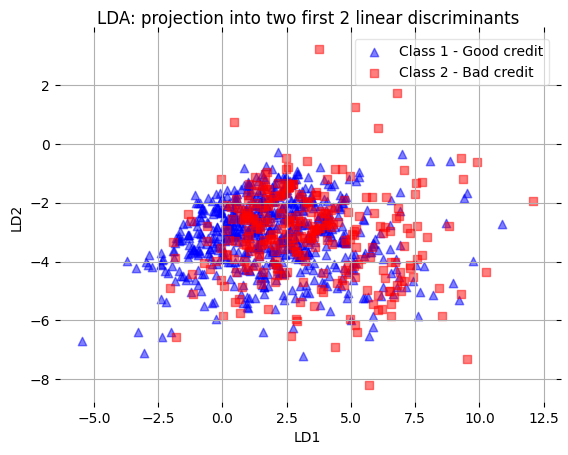

In [ ]:
from matplotlib import pyplot as plt

label_dict = {1: 'Class 1 - Good credit', 2: 'Class 2 - Bad credit'}

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,3),('^', 's'),('blue', 'red')):

        plt.scatter(x= X_lda.values[:,0][ (np.transpose(y.values == label))[0]],
                y= X_lda.values[:,1][ (np.transpose(y.values == label))[0]],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: projection into two first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

As observed in the previous graph, using two LDA components does not improve the classification, since 0 % of the variance is captured by LD2 (as demonstrated previously). Also, the distribution along LD1 shows no clear pattern for classifying both classes. In conclusion, this dataset might not be a good candidate problem to apply LDA, and other classification algorithms should be tested instead.

**Category 6: Support Vector Machines**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:

iris = datasets.load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(data=np.c_[X, y], columns=iris.feature_names + ['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

y_pred

array([2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2,
       1])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
print(f"Accuracy of the SVM model: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy of the SVM model: 91.11%

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.87        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



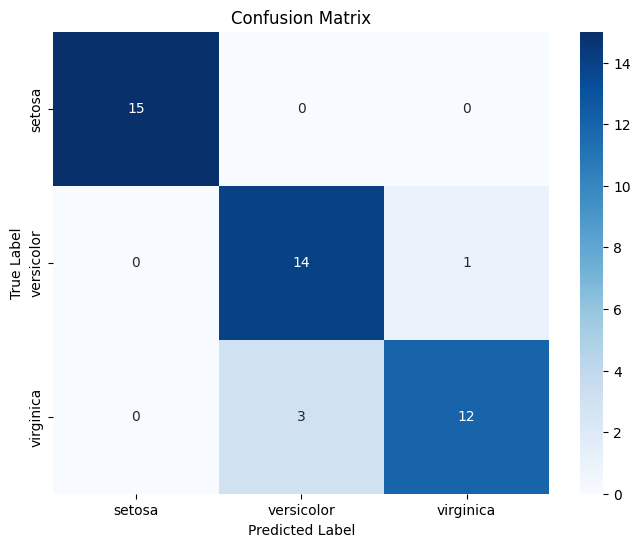

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #Ploting the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

In [ ]:
X_vis = df.iloc[:, [0, 1]].values
y_vis = df.iloc[:, -1].values

X_vis = scaler.fit_transform(X_vis)

In [ ]:
svm_model_vis = SVC(kernel='linear', C=1.0, random_state=42)
svm_model_vis.fit(X_vis, y_vis)

SVC(kernel='linear', random_state=42)

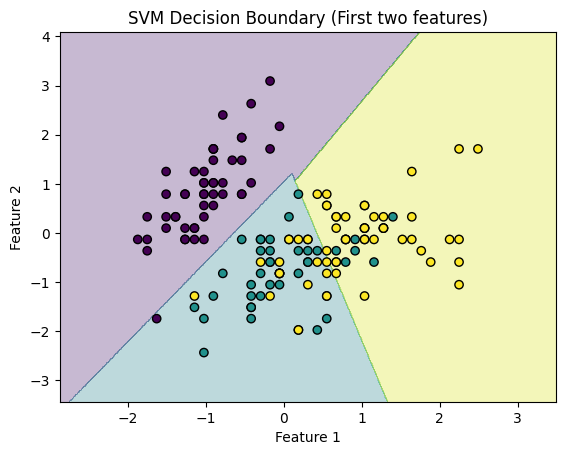

In [ ]:
plot_decision_boundary(X_vis, y_vis, svm_model_vis, 'SVM Decision Boundary (First two features)')


**Category 7: Neural Networks**

In [ ]:
### Obtain data from Fred
fred_api_key = "abcdefghijklmnopqrstuvwxyz123456"

def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, "fred", start_date, end_date)
    return df.reset_index()

### Independent variables series
series = ["CES0500000003", "MANEMP", "PCUOMFGOMFG", "DGORDER", "FEDFUNDS"]
# get data for series
df = get_fred_data(param_list=series, start_date="2010-01-01", end_date="2023-12-31")
df.set_index("DATE", drop=True, inplace=True)
print(df.shape)
df.tail(5)

(168, 5)


,CES0500000003,MANEMP,PCUOMFGOMFG,DGORDER,FEDFUNDS
DATE,,,,,
2023-08-01,33.91,12941,251.093,285317.0,5.33
2023-09-01,34.01,12954,252.368,290883.0,5.33
2023-10-01,34.10,12923,249.119,279021.0,5.33
2023-11-01,34.23,12948,246.497,300639.0,5.33
2023-12-01,34.34,12960,243.266,287397.0,5.33


In [ ]:
### Obtain the dependent variable

data = yf.download(tickers="^GSPC", start="2010-01-01", end="2023-12-31", interval="1mo")
print(data.shape)
data.tail(5)

# Make time zones non-timezone aware so as to allow the join
df.index = df.index.tz_localize(None)
data.index = data.index.tz_localize(None)

# Merge two dataset into one, and remove non-valid data from the dataset
# Fortunately, all data are vaild for this case to test
df2predict = pd.merge(df, data["Adj Close"], left_index=True, right_index=True)
df2predict.isnull().sum()
df2predict = df2predict.dropna()

[*********************100%%**********************]  1 of 1 completed

(168, 6)


In [ ]:
# scale features based on the data
# This section adjusts all data
scaler = MinMaxScaler()
scale_model = scaler.fit(df2predict[series])
df2predict[series] = scale_model.transform(df2predict[series])

# % change for just the target column
df2predict["Adj Close"] = df2predict["Adj Close"].pct_change()

# Drop any missing values
df2predict.dropna(inplace=True)

# Glimpse of data
df2predict.head()

,CES0500000003,MANEMP,PCUOMFGOMFG,DGORDER,FEDFUNDS,Adj Close
DATE,,,,,,
2010-02-01,0.003353,0.022064,0.000000,0.139035,0.015152,0.028514
2010-03-01,0.004191,0.022064,0.018843,0.151198,0.020833,0.058796
2010-04-01,0.006706,0.045425,0.033253,0.156929,0.028409,0.014759
2010-05-01,0.010059,0.068787,0.043229,0.206959,0.028409,-0.081976
2010-06-01,0.010059,0.081765,0.028819,0.176407,0.024621,-0.053882


In [ ]:
X = df2predict[series].values
y = df2predict["Adj Close"].values

test_sz = 0.3
train_sz = int((1 - test_sz) * len(X))
X_train = X[:train_sz]
y_train = y[:train_sz]
X_test = X[train_sz:]
y_test = y[train_sz:]
len(X_train), len(X_test)

(116, 51)

In [ ]:
# Build the model based on Tensorflow protocol

tf.random.set_seed(46)  # first we set random seed
# The output layer for this case
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

# We compile the model specifying loss, and optimizer.
model.compile(
    loss=tf.keras.losses.mae,  # Lost function is MAE, mean absolute error (MAE).
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.9
    ),
    metrics=["mae"],
)  # performance metric is MAE

model.fit(X_train, y_train, epochs=25, batch_size=10)  # epoch and batch size specified

Epoch 1/25
12/12 [==============================] - 0s 3ms/step - loss: 0.3276 - mae: 0.3276
Epoch 2/25
12/12 [==============================] - 0s 2ms/step - loss: 0.1632 - mae: 0.1632
Epoch 3/25
12/12 [==============================] - 0s 2ms/step - loss: 0.1315 - mae: 0.1315
Epoch 4/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0877 - mae: 0.0877
Epoch 5/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.0715
Epoch 6/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.0697
Epoch 7/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.0595
Epoch 8/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.0572
Epoch 9/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0502 - mae: 0.0502
Epoch 10/25
12/12 [==============================] - 0s 2ms/step - loss: 0.0507 - mae: 0.0507
Epoch 11/25
12/12 [==============================] - 0s 2ms/step - lo

In [ ]:
# performance
preds = model.predict(X_test)
mae = tf.metrics.mean_absolute_error(y_true=y_test, y_pred=preds.squeeze()).numpy()
mse = tf.metrics.mean_squared_error(y_true=y_test, y_pred=preds.squeeze()).numpy()
mae, mse

2/2 [==============================] - 0s 5ms/step


(0.25171795, 0.07245903)

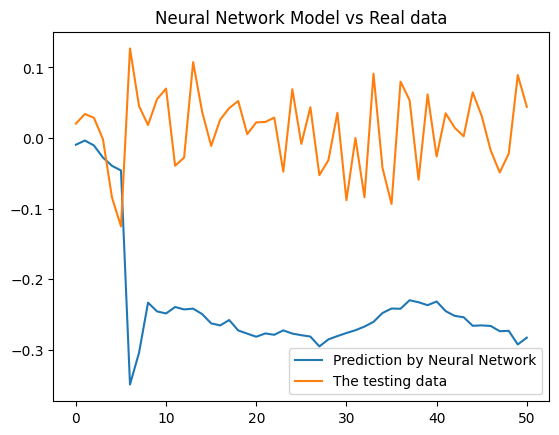

In [ ]:
plt.plot(preds,label="Prediction by Neural Network")
plt.plot(y_test, label="The testing data")
plt.legend()
plt.title('Neural Network Model vs Real data')
plt.show()

# **STEP 4**

**Category 5: Linear Discriminant Analysis (LDA)**


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from mlxtend.plotting import plot_decision_regions

In [ ]:
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1).values
y = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values

In [ ]:
#Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#LDA model
lda = LinearDiscriminantAnalysis()

param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5]
}

In [ ]:
#grid search with cross-validation
grid_search = GridSearchCV(lda, param_grid, cv=5)
grid_search.fit(X_train, y_train)

#best model and its parameters
best_lda = grid_search.best_estimator_
best_params = grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 615, in fit
NotImplementedError: shrinkage not supported with 'svd' solver.

  # scoring?
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.98095238 0.98095238 0.98095238        nan 0.9

In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'shrinkage': None, 'solver': 'svd'}


In [ ]:
#Training
best_lda.fit(X_train, y_train)

#Evaluation
y_pred = best_lda.predict(X_test)

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Accuracy Score: 1.0


In [ ]:
def plot_decision_boundaries(X, y, model, title):
    plt.figure(figsize=(10, 6))

    plot_decision_regions(X, y, clf=model, legend=2)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

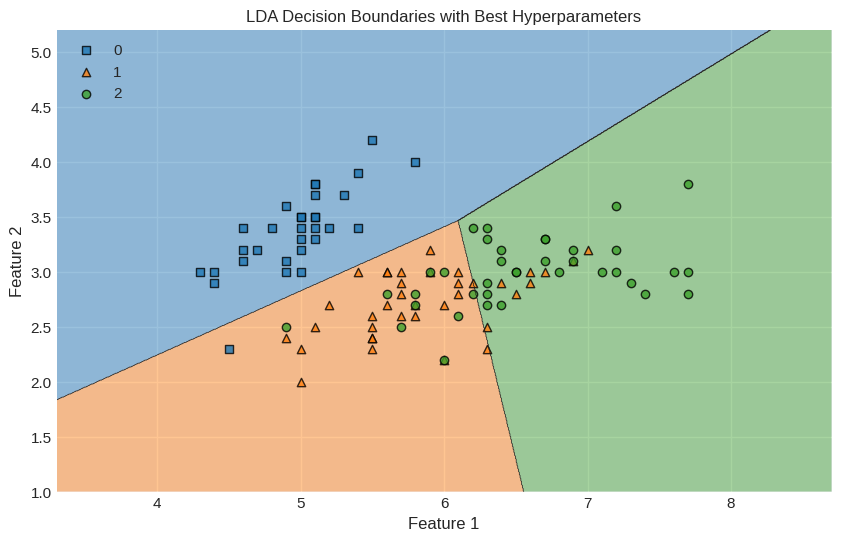

In [ ]:
X_train_2d = X_train[:, :2]
best_lda_2d = LinearDiscriminantAnalysis(**grid_search.best_params_)
best_lda_2d.fit(X_train_2d, y_train)

plot_decision_boundaries(X_train_2d, y_train, best_lda_2d, "LDA Decision Boundaries with Best Hyperparameters")


**Category 6: Support Vector Machines (SVM)**


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [ ]:
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1).values
y = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values

y_binary = np.where(y == 1, 1, 0)  # 1 for 'versicolor', 0 for 'setosa' and 'virginica'

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

In [ ]:
#tune hyperparameters manually
best_score = 0
best_params = {}

for C in [0.1, 1, 10]:
    for gamma in [0.1, 1]:
        for kernel in ['rbf', 'linear']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel)
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_score)

Best Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy: 1.0


In [ ]:
#training
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

In [ ]:
# Evaluation
y_pred = best_svm.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Accuracy Score: 1.0


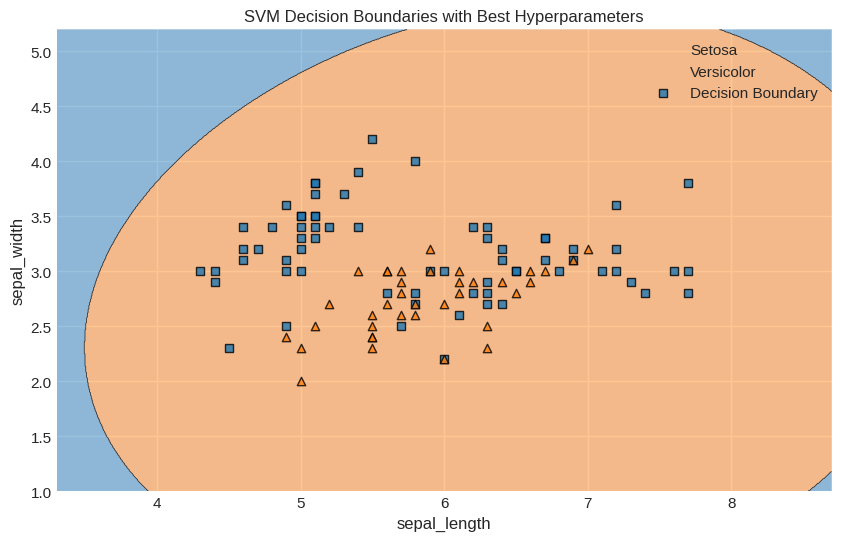

In [ ]:
plt.figure(figsize=(10, 6))

plot_decision_regions(X_train, y_train, clf=best_svm, legend=2,
                      filler_feature_values={2: X[:, 2].mean(), 3: X[:, 3].mean()},
                      filler_feature_ranges={2: X[:, 2].std() * 2, 3: X[:, 3].std() * 2})

plt.xlabel(iris.columns[0])
plt.ylabel(iris.columns[1])
plt.title('SVM Decision Boundaries with Best Hyperparameters')
plt.legend(['Setosa', 'Versicolor', 'Decision Boundary'])
plt.show()

**Category 7: Neural Networks**


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
#dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#preprocess
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
 #Defining the function to create the neural network model
def create_model(learning_rate=0.01, dropout_rate=0.0):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.0, 0.2],
    'batch_size': [32, 64],
    'epochs': [5, 10]
}

In [ ]:
skip_grid_search = True

if not skip_grid_search:
    # Perform Grid Search with Cross-Validation
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_result.best_params_)

    # Use the best hyperparameters
    best_params = grid_result.best_params_
else:
    # Default parameters for quick demonstration
    best_params = {
        'model__learning_rate': 0.01,
        'model__dropout_rate': 0.2,
        'batch_size': 32,
        'epochs': 5
    }



In [ ]:
best_model = create_model(learning_rate=best_params['model__learning_rate'], dropout_rate=best_params['model__dropout_rate'])
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 - 49s - 26ms/step - accuracy: 0.9431 - loss: 0.1907 - val_accuracy: 0.9752 - val_loss: 0.0788
Epoch 2/5
1875/1875 - 96s - 51ms/step - accuracy: 0.9639 - loss: 0.1244 - val_accuracy: 0.9768 - val_loss: 0.0809
Epoch 3/5
1875/1875 - 64s - 34ms/step - accuracy: 0.9684 - loss: 0.1130 - val_accuracy: 0.9797 - val_loss: 0.0728
Epoch 4/5
1875/1875 - 41s - 22ms/step - accuracy: 0.9713 - loss: 0.1026 - val_accuracy: 0.9778 - val_loss: 0.0875
Epoch 5/5
1875/1875 - 37s - 20ms/step - accuracy: 0.9727 - loss: 0.1029 - val_accuracy: 0.9786 - val_loss: 0.0846


In [ ]:
scores = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {scores[1]*100:.2f}%")


Test Accuracy: 97.86%


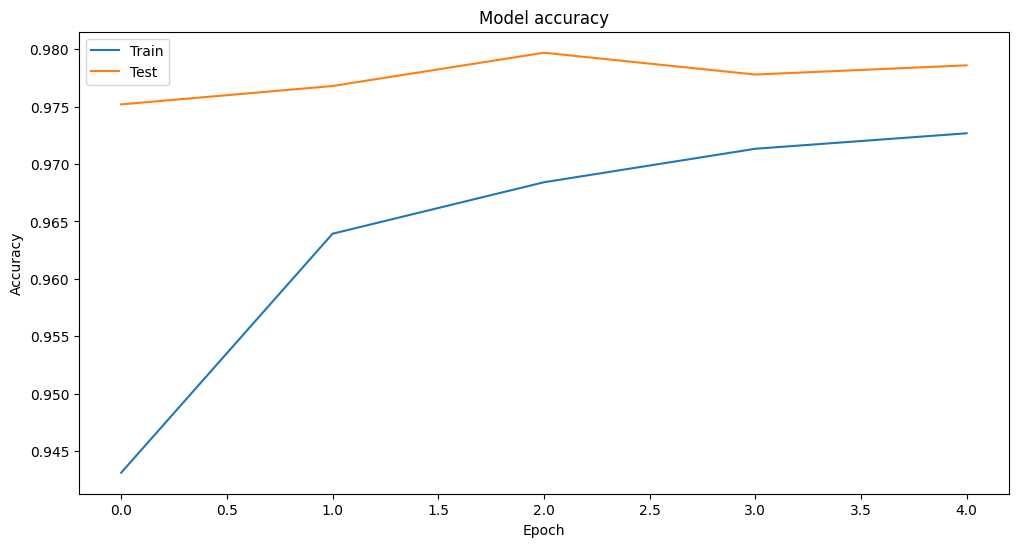

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

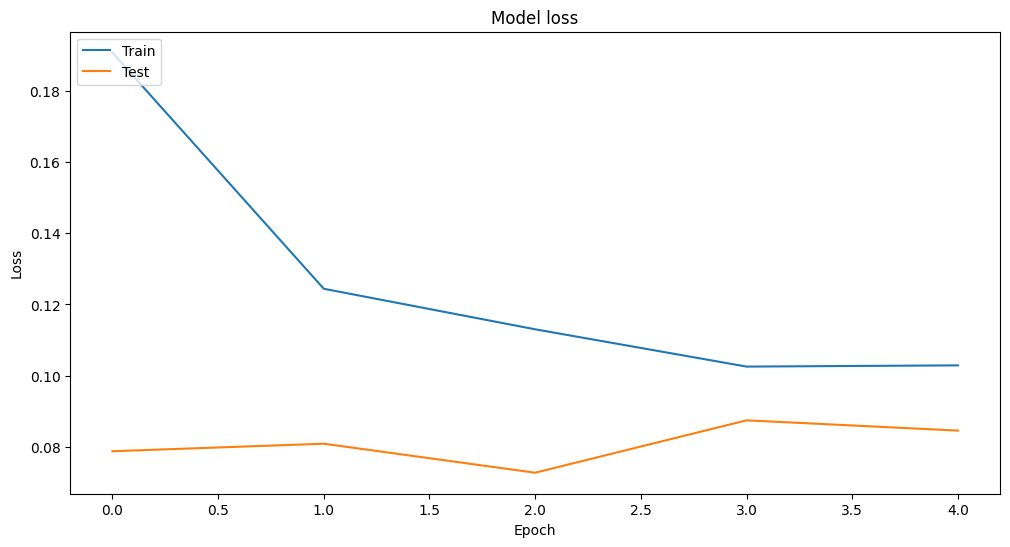

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()